In [1]:
import sys
sys.path.insert(0, '.')
from utils import *

# Some simple forecasting methods

We are going to start with some really simple models to predict time series.


In [4]:
d = pd.read_csv('data/aus_production.csv')
aus_production = (
    d
    .assign(Date=pd.to_datetime(d.Quarter.str.replace(' ', '')))
    .pipe(compute, lambda x: dict(Year=x.Date.dt.year))
    .set_index('Date', drop=False)
    .drop(columns='Date Year'.split())
)


/var/folders/72/x6_kg98117nd5xkqbx_bl3dc0000gn/T/ipykernel_41835/1257075650.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  .assign(Date=pd.to_datetime(d.Quarter.str.replace(' ', '')))


In [5]:
aus_production

,Quarter,Beer,Tobacco,Bricks,Cement,Electricity,Gas
Date,,,,,,,
1956-01-01,1956 Q1,284,5225.0,189.0,465,3923,5
1956-04-01,1956 Q2,213,5178.0,204.0,532,4436,6
1956-07-01,1956 Q3,227,5297.0,208.0,561,4806,7
1956-10-01,1956 Q4,308,5681.0,197.0,570,4418,6
1957-01-01,1957 Q1,262,5577.0,187.0,529,4339,5
...,...,...,...,...,...,...,...
2009-04-01,2009 Q2,398,NaN,NaN,2160,57471,238
2009-07-01,2009 Q3,419,NaN,NaN,2325,58394,252
2009-10-01,2009 Q4,488,NaN,NaN,2273,57336,210


In [6]:
bricks = aus_production['1970-01-01':'2004-01-01']

In [9]:
class SimpleTSModel:
    """Simple TS model base class."""
    def __init__(self, y):
        """Determine y data and sampling frequency."""
        if not hasattr(y, 'index'):
            y = pd.Series(y)
        if hasattr(y.index, 'inferred_freq'):
            self.y = y.asfreq(y.index.inferred_freq)
            self.freq = self.y.index.freq
        else:
            self.y = y.copy()
            self.freq = None

    def fit(self):
        """Nothing to do here, but in other libraries this is a method that does things."""
        return self

    def forecast(self, dt=None, end=None, periods=None):
        """Make a forward-looking prediction."""
        assert sum([dt is None, end is None, periods is None]) == 2
        tmax = self.y.index.max()
        if dt is not None:
            end = tmax + (pd.to_timedelta(dt) if self.freq else dt)
        elif end is not None:
            end = pd.to_datetime(end) if self.freq else end
        elif periods is not None:
            end = tmax + periods * (self.freq or 1)
        return self.predict(tmax + 1 * (self.freq or 1), end)

    def _normalize_times(self, start, end):
        """Do some tedious datetime manipulation."""
        Y = self.y
        t0 = Y.index.min()
        if start is None:
            start = t0
        if end is None:
            end = Y.index.max()
        if self.freq is not None:
            start = pd.to_datetime(start)
            end = pd.to_datetime(end)
        if self.freq:
            index = pd.date_range(t0, end, freq=self.freq)
        else:
            index = np.arange(t0, end+1)
        return start, end, index

class TSMean(SimpleTSModel):
    """The future will look like the average of the past."""
    def predict(self, start=None, end=None):
        # value is always the mean
        Y = self.y
        start, end, index = self._normalize_times(start, end)
        m = Y.mean()
        out = pd.Series(m, index=index)
        out = out.loc[start:].copy()
        return out

class TSNaive(SimpleTSModel):
    """Tomorrow will look like today."""
    def predict(self, start=None, end=None):
        # tomorrow probably same as today
        Y = self.y
        start, end, index = self._normalize_times(start, end)
        out = pd.Series(np.nan, index=index)
        out.loc[:Y.index.max()] = Y
        out = out.shift(1)
        out.loc[Y.index.max():] = Y.iloc[-1]
        out = out.loc[start:].copy()
        return out.copy()

class TSNaiveSeasonal(SimpleTSModel):
    """Next year will fluctuate the same way as this year."""
    def __init__(self, y, lag):
        super(TSNaiveSeasonal, self).__init__(y)
        self.lag = lag
        assert self.y.index.min() + lag * (self.freq or 1) < self.y.index.max(), \
            'lag must be less than input timeseries'

    def predict(self, start=None, end=None):
        # tomorrow probably same as this time last year/month/whatever
        Y, lag = self.y, self.lag
        start, end, index = self._normalize_times(start, end)
        out = pd.Series(np.nan, index=index)
        out.loc[:Y.index.max()] = Y
        out = out.shift(lag)
        i = 0
        while np.isnan(out.iloc[-1]):
            mask = out.isna()
            out[mask] = out.shift(lag)[mask]
            i += 1
        out = out.loc[start:].copy()
        return out.copy()

class TSDrift(SimpleTSModel):
    """Draw a line from t=0 thru today, and extrapolate to tomorrow."""
    def predict(self, start=None, end=None):
        # value extrapolated based on slope wrt first observation
        # TODO: might be slightly wrong
        # doesn't *quite* agree with R's RW(Y~drift()) ?
        Y = self.y
        Y0 = Y.values[0]
        YT = Y.shift(-1)
        start, end, index = self._normalize_times(start, end)
        YT = pd.Series(np.nan, index=index)
        YT.loc[Y.index.min():Y.index.max()] = Y
        YT = YT.shift(1)
        YT.iloc[0] = Y.iloc[0]
        h = pd.Series(1, index=index)
        extrap_mask = YT.isna()
        h.loc[YT.isna()] = np.arange(1, extrap_mask.sum()+1)
        YT.loc[extrap_mask] = Y.iloc[-1]
        x = np.maximum(1, np.arange(len(YT)) - 1)
        out = YT + h * ((YT - Y0) / x)
        out.iloc[0] = np.nan
        out = out.loc[start:].copy()
        return out.copy()

## Mean Model
* Just predict future as the mean of past values

In [10]:
bricks

,Quarter,Beer,Tobacco,Bricks,Cement,Electricity,Gas
Date,,,,,,,
1970-01-01,1970 Q1,387,6807.0,386.0,1049,12328,12
1970-04-01,1970 Q2,357,7612.0,428.0,1134,14493,18
1970-07-01,1970 Q3,374,7862.0,434.0,1229,15664,23
1970-10-01,1970 Q4,466,7126.0,417.0,1188,13781,20
1971-01-01,1971 Q1,410,7255.0,385.0,1058,13299,19
...,...,...,...,...,...,...,...
2003-01-01,2003 Q1,435,4362.0,387.0,1831,51415,172
2003-04-01,2003 Q2,380,5210.0,415.0,1892,51379,204
2003-07-01,2003 Q3,421,5258.0,440.0,2227,54808,232


In [11]:
m = TSMean(bricks.Bricks)

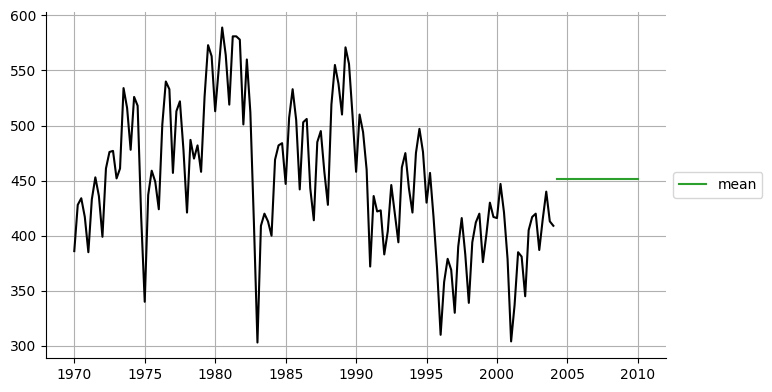

In [12]:
fig, ax = plt.subplots()
ax.plot(bricks.Bricks, color='k')
ax.plot(m.forecast(end='2010'), color='C2', label='mean')
ax.legend(**legend_right)
ax.grid()

## Naive

* Simply set all forecasts to be the value of the last observation
$$\hat{y}_{T+h|T} = y_{T}.$$


In [13]:
n = TSNaive(bricks.Bricks).fit()

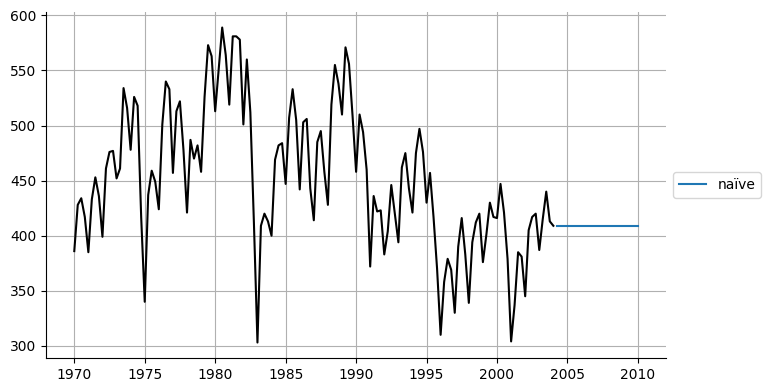

In [14]:
fig, ax = plt.subplots()
ax.plot(bricks.Bricks, color='k')
ax.plot(n.forecast(end='2010'), color='C0', label='naïve')
ax.legend(**legend_right)
ax.grid()

## Seasonal naive method
* Each forecast will be equal to the last observed value from the same season
$$\hat{y}_{T+h|T} = y_{T+h-m(k+1)},$$

In [15]:
s = TSNaiveSeasonal(bricks.Bricks, 4)

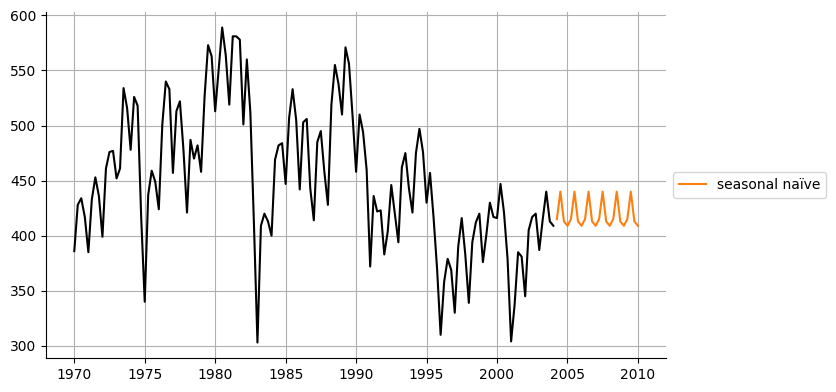

In [16]:
fig, ax = plt.subplots()
ax.plot(bricks.Bricks, color='k')
ax.plot(s.forecast(end='2010'), color='C1', label='seasonal naïve')
ax.legend(**legend_right)
ax.grid()

## Drift method
* Method to capture the increase or decrease over time
* Equivalent to drawing a line between the first and last observations, and extrapolating it into the future

$$ \hat{y}_{T+h|T} = y_{T} + \frac{h}{T-1}\sum_{t=2}^T (y_{t}-y_{t-1}) = y_{T} + h \left( \frac{y_{T} -y_{1}}{T-1}\right).$$

In [17]:
dr = TSDrift(bricks.Bricks)

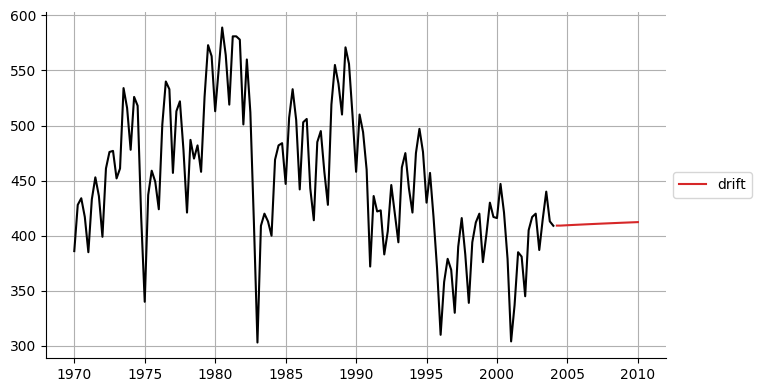

In [18]:
fig, ax = plt.subplots()
ax.plot(bricks.Bricks, color='k')
ax.plot(dr.forecast(end='2010'), color='C3', label='drift')
ax.legend(**legend_right)
ax.grid()

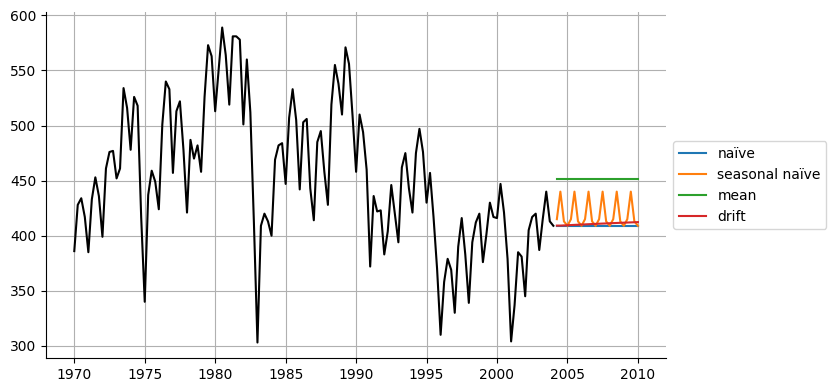

In [19]:
fig, ax = plt.subplots()
ax.plot(bricks.Bricks, color='k')
ax.plot(n.forecast(end='2010'), color='C0', label='naïve')
ax.plot(s.forecast(end='2010'), color='C1', label='seasonal naïve')
ax.plot(m.forecast(end='2010'), color='C2', label='mean')
ax.plot(dr.forecast(end='2010'), color='C3', label='drift')
ax.legend(**legend_right)
ax.grid()

## Another example: Australian quarterly beer production

In [20]:
Y = aus_production.Beer
Ytrain = Y[:'2006']
m = TSMean(Ytrain)
n = TSNaive(Ytrain).fit()
s = TSNaiveSeasonal(Ytrain, 4)
dr = TSDrift(Ytrain)

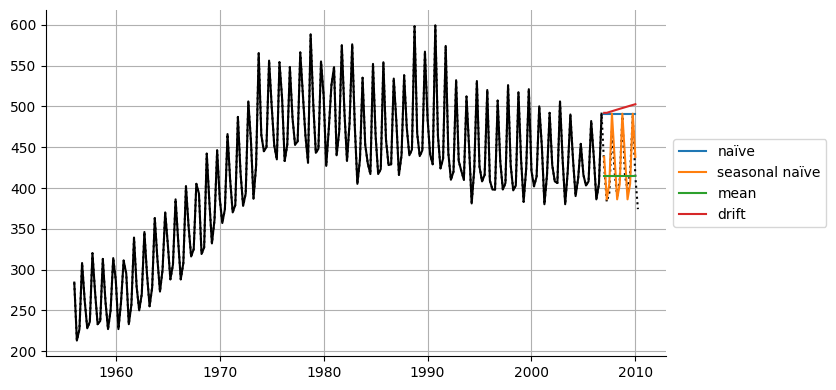

In [22]:
fig, ax = plt.subplots()
ax.plot(Ytrain, 'k')
ax.plot(Y, 'k:')
ax.plot(n.forecast(end='2010'), color='C0', label='naïve')
ax.plot(s.forecast(end='2010'), color='C1', label='seasonal naïve')
ax.plot(m.forecast(end='2010'), color='C2', label='mean')
ax.plot(dr.forecast(end='2010'), color='C3', label='drift')
ax.legend(**legend_right)
ax.grid()

## Fitted values
* How well the method fits the data
* How well the method forecasts

* $\hat{y}_{t|t-1}$ is the forecast of $y_t$ based on observations $y_{1},\dots,y_{t-1}$
* We call these "fitted values"
* Sometimes drop the subscript: $\hat{y}_{t} = \hat{y}_{t|t-1}$
* $\hat{y}_{t} = \overline{y}_t$ for average method
* $\hat{y}_{t} = y_{t-1} + (y_t - y_1)/(T-1)$ for drift method

## Residuals

* difference between observed value and its fitted value
* Assumptions:
    * $\{e_t\}$ uncorrelated. If they aren't, then information left in residuals that should be used in computing forecasts
    * $\{e_t\}$ have mean zero. If they don't, then forecasts are biased
* Useful properties (for distributions & prediction intervals
    * $\{e_t\}$ have constant variance
    * $\{e_t\}$ are normally distributed

In [23]:
GOOG = (
    pd.read_csv('data/gafa_stock.csv')
    .query("Symbol == 'GOOG'")
    .sort_values('Date')
    .reset_index(drop=True)
    .pipe(compute, lambda x: dict(Date = pd.to_datetime(x.Date, format='%Y-%m-%d')))
)

In [39]:
GOOG_2015 = GOOG.query('Date.dt.year == 2015')

In [40]:
len(GOOG_2015)

252

In [47]:
Y = GOOG.Close
Ytrain = GOOG_2015.Close
nsamples = len(GOOG_2015)
m = TSMean(Ytrain)
n = TSNaive(Ytrain).fit()
s = TSNaiveSeasonal(Ytrain, nsamples - 2)
dr = TSDrift(Ytrain)

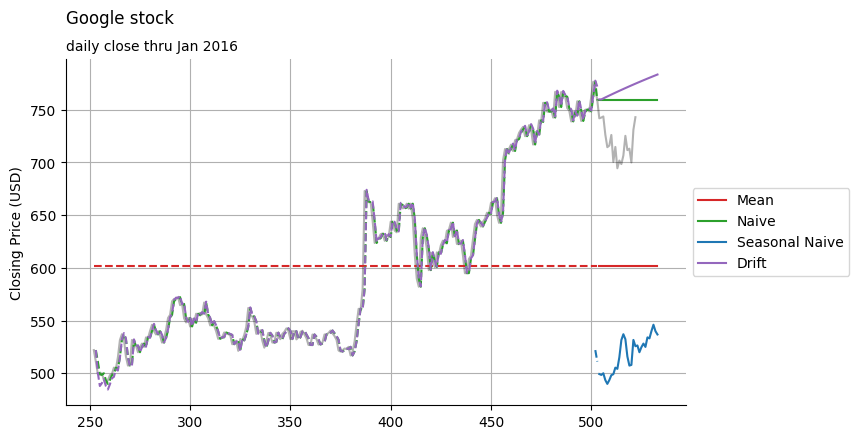

In [48]:
fig, ax = plt.subplots()
ax.plot(Y[GOOG.Date.between('2015-01-01', '2016-01-30')], color='k', alpha=0.3)
c = 'C3 C2 C0 C4'.split()
ax.plot(m.predict(),  ls='--', color=c[0])
ax.plot(n.predict(),  ls='--', color=c[1])
ax.plot(s.predict(),  ls='--', color=c[2])
ax.plot(dr.predict(), ls='--', color=c[3])
ax.plot(m.forecast(30),  color=c[0], label='Mean')
ax.plot(n.forecast(30),  color=c[1], label='Naive')
ax.plot(s.forecast(30),  color=c[2], label='Seasonal Naive')
ax.plot(dr.forecast(30), color=c[3], label='Drift')
ax.set(ylabel='Closing Price (USD)')
ax.legend(loc='center left', bbox_to_anchor=[1, .5])
suptitle('Google stock')
ax.set(title='daily close thru Jan 2016')
ax.grid()

In [45]:
results = GOOG_2015.assign(
    mean=m.predict(),
    naive=n.predict(),
    naive_seasonal=s.predict(),
    drift=dr.predict(),
    resid_mean=m.predict() - Ytrain,
    resid_naive=n.predict() - Ytrain,
    resid_naive_seasonal=s.predict() - Ytrain,
    resid_drift=dr.predict() - Ytrain,
)
results.tail(20)


,Symbol,Open,High,Low,Close,Adj_Close,Volume,Date,mean,naive,naive_seasonal,drift,resid_mean,resid_naive,resid_naive_seasonal,resid_drift
484,GOOG,766.010010,768.994995,745.630005,752.539978,752.539978,2590600.0,2015-12-03,601.550547,762.380005,NaN,763.420881,-150.989431,9.840027,NaN,10.880903
485,GOOG,753.099976,768.489990,750.000000,766.809998,766.809998,2757300.0,2015-12-04,601.550547,752.539978,NaN,753.533953,-165.259451,-14.270020,NaN,-13.276045
486,GOOG,767.770020,768.729980,755.090027,763.250000,763.250000,1812300.0,2015-12-07,601.550547,766.809998,NaN,767.860952,-161.699453,3.559998,NaN,4.610952
487,GOOG,757.890015,764.799988,754.200012,762.369995,762.369995,1829500.0,2015-12-08,601.550547,763.250000,NaN,764.281249,-160.819448,0.880005,NaN,1.911254
488,GOOG,759.169983,764.229980,737.000977,751.609985,751.609985,2700000.0,2015-12-09,601.550547,762.369995,NaN,763.393111,-150.059438,10.760010,NaN,11.783126
489,GOOG,752.849976,755.849976,743.830017,749.460022,749.460022,1984900.0,2015-12-10,601.550547,751.609985,NaN,752.583172,-147.909475,2.149963,NaN,3.123150
490,GOOG,741.159973,745.710022,736.750000,738.869995,738.869995,2224400.0,2015-12-11,601.550547,749.460022,NaN,750.420032,-137.319448,10.590027,NaN,11.550037
491,GOOG,741.789978,748.729980,724.169983,747.770020,747.770020,2412500.0,2015-12-14,601.550547,738.869995,NaN,739.781475,-146.219473,-8.900025,NaN,-7.988545
492,GOOG,753.000000,758.080017,743.010010,743.400024,743.400024,2666200.0,2015-12-15,601.550547,747.770020,NaN,748.714925,-141.849477,4.369996,NaN,5.314901
493,GOOG,750.000000,760.590027,739.434998,758.090027,758.090027,1993300.0,2015-12-16,601.550547,743.400024,NaN,744.322784,-156.539480,-14.690003,NaN,-13.767243


In [49]:
def plot_tsresiduals(Y, y, acf_lags=np.r_[1:26]):
    """Plot timeseries residuals for ground truth Y and estimate y."""
    fig = plt.figure()
    gs = plt.GridSpec(3, 2, figure=fig)
    ts_ax = fig.add_subplot(gs[0, :])
    axs = np.array([ts_ax] + [fig.add_subplot(gs[i, j]) for j in (0, 1) for i in (1, 2)])
    ax, rax, hax, acfax, pacfax = axs
    mask = ~(np.isnan(Y) | np.isnan(y))
    Y, y = Y[mask], y[mask]
    dy = Y - y
    ax.plot(Y, color='k')
    ax.plot(y)
    ax.set(title='Time Series')
    lim = 1.1 * max(-dy.min(), dy.max())
    lim = -lim, lim
    rax.plot(dy)
    rax.set(ylim=lim, title='Residuals')
    sns.histplot(dy, bins=np.linspace(lim[0], lim[1], 22),
             kde=True, stat='density', ax=hax)
    hax.set(title='Residual Distribution')
    sm.graphics.tsa.plot_acf(dy, lags=acf_lags, ax=acfax)
    acfax.set_ylim(-0.5, 0.5)
    sm.graphics.tsa.plot_pacf(dy, lags=acf_lags, ax=pacfax)
    pacfax.set_ylim(-0.5, 0.5)
    for a in axs.ravel():
        a.grid()
    plt.tight_layout()
    return fig, axs


/Users/gabrielasoares/.local/share/virtualenvs/cda-m6uw-1w4/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


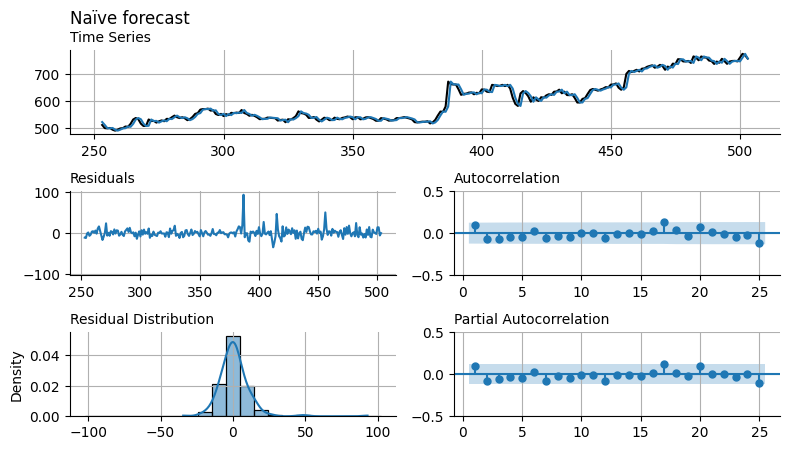

In [50]:
plot_tsresiduals(Ytrain, results.naive)
suptitle('Naïve forecast')
plt.subplots_adjust(top=.9)

/Users/gabrielasoares/.local/share/virtualenvs/cda-m6uw-1w4/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


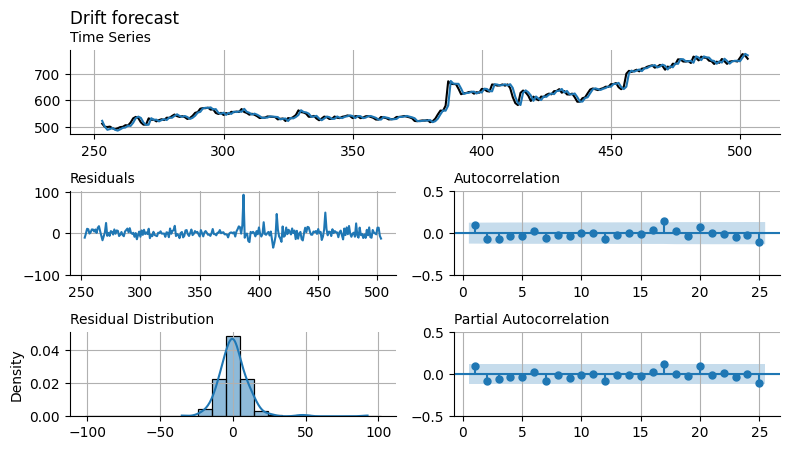

In [52]:
plot_tsresiduals(Ytrain, results.drift)
suptitle('Drift forecast')
plt.subplots_adjust(top=.9)

## Forecast Distributions

* All forecasts have an uncertainty
* We express the uncertainty in our forecasts using a probability distribution
* Describes the probability of observing possible future values using the fitted model
* Most time series models produce normally distributed forecasts

## Prediction intervals


In [53]:
mult = pd.DataFrame(dict(Percentage=np.r_[50:90:5, 90:100]))
mult['Multiplier'] = stats.norm.isf((1 - mult.Percentage/100) / 2)
mult = mult.set_index('Percentage')
mult

,Multiplier
Percentage,
50,0.674490
55,0.755415
60,0.841621
65,0.934589
70,1.036433
75,1.150349
80,1.281552
85,1.439531
90,1.644854


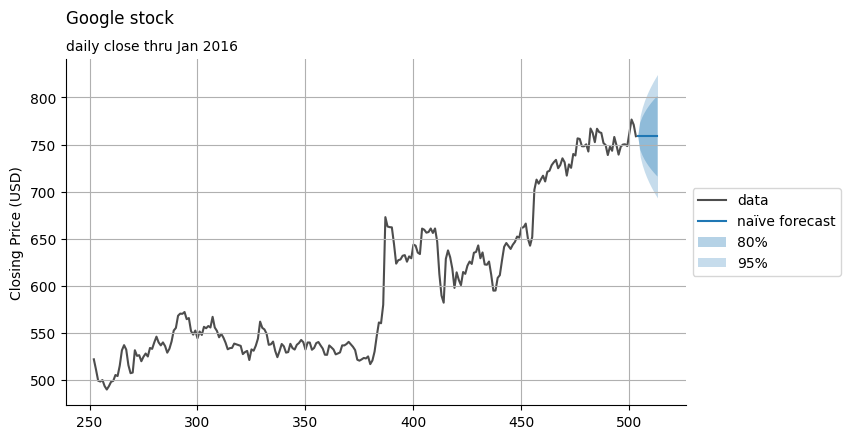

In [54]:
fig, ax = plt.subplots()
g = GOOG[GOOG.Date.lt('2016-02-01')]
ax.plot(GOOG_2015.Close, color='.3', zorder=-10, label='data')
fc = n.forecast(10)
ax.plot(fc, lw=1.5, label='naïve forecast')
sigma = results.resid_naive.std()
m80, m95 = mult.Multiplier.loc[[80, 95]]
didx = fc.index - fc.index.min()
ax.fill_between(fc.index, fc - m80*sigma * np.sqrt(didx), fc + m80*sigma * np.sqrt(didx),
                alpha=.33, lw=0, label='80%')
ax.fill_between(fc.index, fc - m95*sigma * np.sqrt(didx), fc + m95*sigma * np.sqrt(didx),
                alpha=.25, color='C0', lw=0, label='95%')
ax.legend(loc='center left', bbox_to_anchor=[1, .5])
suptitle('Google stock')
ax.set(title='daily close thru Jan 2016', ylabel='Closing Price (USD)')
ax.grid()

## Forecasting with decomposition

In [55]:
d = pd.read_csv('data/us_employment.csv')
d = us_retail_employment = (
    d
    .assign(date=pd.to_datetime(d.Month, format='%Y %b'))
    .pipe(compute, lambda x: dict(year=x.date.dt.year))
    .query("year >= 1990 and Title == 'Retail Trade'")
    .set_index('date')
    .drop(columns='year Series_ID'.split())
)
us_retail_employment

,Month,Title,Employed
date,,,
1990-01-01,1990 Jan,Retail Trade,13255.8
1990-02-01,1990 Feb,Retail Trade,12966.3
1990-03-01,1990 Mar,Retail Trade,12938.2
1990-04-01,1990 Apr,Retail Trade,13012.3
1990-05-01,1990 May,Retail Trade,13108.3
...,...,...,...
2019-05-01,2019 May,Retail Trade,15691.6
2019-06-01,2019 Jun,Retail Trade,15775.5
2019-07-01,2019 Jul,Retail Trade,15785.9


In [56]:
stl = sm.tsa.STL(d.Employed).fit()

In [57]:
s_stl = TSNaiveSeasonal(stl.seasonal, 12)

In [58]:
dr_stl = TSDrift(d.Employed - stl.seasonal)


In [59]:
from datetime import timedelta
end = us_retail_employment.index.max() + + timedelta(days=365*4)

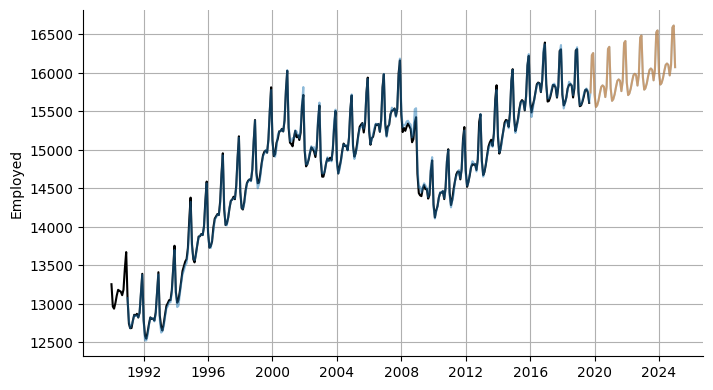

In [61]:
fig, ax = plt.subplots(figsize=sizets)
ax.plot(d.Employed, 'k')
end = pd.to_datetime('2025-01-01')
ax.plot(s_stl.predict(end=end) + dr_stl.predict(end=end), alpha=0.5)
ax.plot(s_stl.forecast(end=end) + dr_stl.forecast(end=end), alpha=0.5)
ax.set(ylabel='Employed')
ax.grid()

/Users/gabrielasoares/.local/share/virtualenvs/cda-m6uw-1w4/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


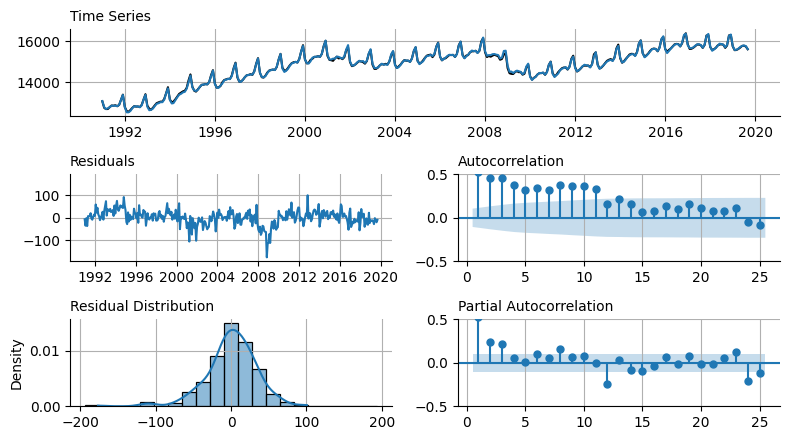

In [69]:
plot_tsresiduals(d.Employed, s_stl.predict() + dr_stl.predict());

## Evaluating forecast accuracy

In [62]:
aus_production['1995':]

,Quarter,Beer,Tobacco,Bricks,Cement,Electricity,Gas
Date,,,,,,,
1995-01-01,1995 Q1,426,4714.0,430.0,1626,41768,131
1995-04-01,1995 Q2,408,3939.0,457.0,1703,43686,167
1995-07-01,1995 Q3,416,6137.0,417.0,1733,46022,181
1995-10-01,1995 Q4,520,4739.0,370.0,1545,42800,145
1996-01-01,1996 Q1,409,4275.0,310.0,1526,43661,133
...,...,...,...,...,...,...,...
2009-04-01,2009 Q2,398,NaN,NaN,2160,57471,238
2009-07-01,2009 Q3,419,NaN,NaN,2325,58394,252
2009-10-01,2009 Q4,488,NaN,NaN,2273,57336,210


In [63]:
aus_production[aus_production.index.quarter == 1]

,Quarter,Beer,Tobacco,Bricks,Cement,Electricity,Gas
Date,,,,,,,
1956-01-01,1956 Q1,284,5225.0,189.0,465,3923,5
1957-01-01,1957 Q1,262,5577.0,187.0,529,4339,5
1958-01-01,1958 Q1,272,5758.0,199.0,554,4608,5
1959-01-01,1959 Q1,261,5478.0,208.0,573,4883,5
1960-01-01,1960 Q1,286,5980.0,242.0,621,5387,6
1961-01-01,1961 Q1,295,6022.0,241.0,688,5709,6
1962-01-01,1962 Q1,279,6072.0,229.0,637,6098,6
1963-01-01,1963 Q1,294,6051.0,231.0,674,6707,6
1964-01-01,1964 Q1,313,5890.0,293.0,797,7469,6


In [65]:
recent_production = aus_production['1992':]
split = '2007-12-01'
beer_train = recent_production[:split]
beer_test = recent_production[split:]

Ytrain = beer_train.Beer
ms = dict(
    Drift = TSDrift(Ytrain),
    Mean = TSMean(Ytrain),
    Naive = TSNaive(Ytrain),
    SeasonalNaive = TSNaiveSeasonal(Ytrain, 4),
)

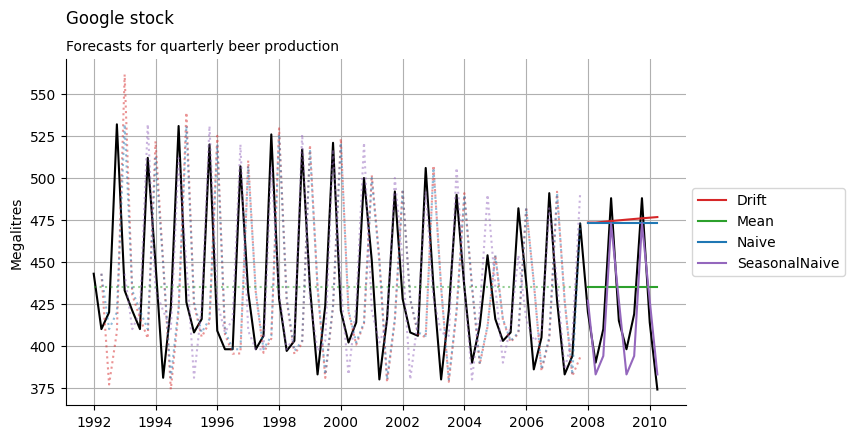

In [66]:
fig, ax = plt.subplots()
Y = recent_production.Beer
ax.plot(Y, color='k')
c = 'C3 C2 C0 C4'.split()
for ((label, model), c) in zip(ms.items(), c):
    ax.plot(model.predict(),  ls=':', color=c, alpha=.5)
    ax.plot(model.forecast(end=Y.index.max()),  color=c, label=label)
ax.set(ylabel='Megalitres')
ax.legend(loc='center left', bbox_to_anchor=[1, .5])
suptitle('Google stock')
ax.set(title='Forecasts for quarterly beer production')
ax.grid()


In [67]:
def MAE(Y, y):
    """Mean absolute error."""
    return np.mean(np.abs(Y - y))


def MAPE(Y, y):
    """Mean absolute percent error."""
    return 100 * np.mean(np.abs((Y - y) / Y))




def tsaccuracy(Ytest, models):
    """Gather some metrics for a few models."""
    fs = RMSE, MAE, MAPE
    return pd.DataFrame({
        label: [f(Ytest, model.predict(Ytest.index.min(), Ytest.index.max()))
                for f in (RMSE, MAE, MAPE)]
        for (label, model) in models.items()
    }, index=[f.__name__ for f in fs]).T

In [68]:
tsaccuracy(beer_test.Beer, ms)

,RMSE,MAE,MAPE
Drift,64.367670,58.524029,14.483635
Mean,38.447245,34.825000,8.283390
Naive,62.692902,57.400000,14.184424
SeasonalNaive,14.310835,13.400000,3.168503


In [ ]:
results.naive